In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.utils import simple_preprocess

import spacy

import re
import json
from html.parser import HTMLParser
from io import StringIO

In [3]:
train_data = pd.read_json('../input/dataset_fr_train.json', lines=True)

test_data = pd.read_json('../input/dataset_fr_test.json', lines=True)

valid_data= pd.read_json('../input/dataset_fr_dev.json', lines=True)

train_data.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,fr_0424335,product_fr_0297678,reviewer_fr_0961886,1,A déconseiller - Article n'a fonctionné qu'une...,Brumisateur à pompe,fr,beauty
1,fr_0452615,product_fr_0613288,reviewer_fr_0857499,1,Si vous voulez être déçu achetez le produit ! ...,Insatisfaisant,fr,baby_product
2,fr_0407673,product_fr_0571250,reviewer_fr_0383240,1,"Écran de mauvaise qualité, car il s'use en peu...",Ne recommande pas,fr,pc
3,fr_0579191,product_fr_0030168,reviewer_fr_0729693,1,Cet engin ne sert à rien les sons sont pourris...,A éviter!,fr,musical_instruments
4,fr_0931533,product_fr_0468261,reviewer_fr_0734066,1,Très beau produit mais la grue n'a pas fonctio...,Déçue,fr,toy


In [4]:
# convert starts into sentiments

sentiments_dict = {1: 0,
            2: 0,
            3: 1,
            4: 2,
            5: 2}

def stars_to_sentiment(dataset):
    dataset['sentiment'] = dataset['stars'].map(sentiments_dict)
    dataset = dataset[['review_body','sentiment']]
    return dataset

df_train = stars_to_sentiment(train_data)
df_test = stars_to_sentiment(test_data)
df_valid = stars_to_sentiment(valid_data)

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras import models, layers, optimizers
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras import metrics

import bz2
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
import re

%matplotlib inline

In [6]:
train_labels, train_texts = df_train['sentiment'].values.tolist(), df_train['review_body'].values.tolist()
test_labels, test_texts = df_test['sentiment'].values.tolist(), df_test['review_body'].values.tolist()
val_labels, val_texts = df_valid['sentiment'].values.tolist(), df_valid['review_body'].values.tolist()

In [7]:
import re
NON_ALPHANUM = re.compile(r'[\W]')
NON_ASCII = re.compile(r'[^a-z0-1\s]')
def normalize_texts(texts):
    normalized_texts = []
    for text in texts:
        lower = text.lower()
        no_punctuation = NON_ALPHANUM.sub(r' ', lower)
        no_non_ascii = NON_ASCII.sub(r'', no_punctuation)
        normalized_texts.append(no_non_ascii)
    return normalized_texts
        
train_texts = normalize_texts(train_texts)
test_texts = normalize_texts(test_texts)
val_texts = normalize_texts(val_texts)

In [9]:
# convert labels to one-hot encoding

from keras.utils import to_categorical
from numpy import array

train_labels = to_categorical(array(train_labels))
test_labels = to_categorical(array(test_labels))
val_labels = to_categorical(array(val_labels))

In [11]:
MAX_FEATURES = 12000
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(train_texts)
train_texts = tokenizer.texts_to_sequences(train_texts)
val_texts = tokenizer.texts_to_sequences(val_texts)
test_texts = tokenizer.texts_to_sequences(test_texts)

In [12]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

train_texts = pad_sequences(train_texts, padding='post', maxlen=maxlen)
test_texts = pad_sequences(test_texts, padding='post', maxlen=maxlen)
val_texts = pad_sequences(val_texts, padding='post', maxlen=maxlen)

In [18]:
# preparing the embedding dictionnary

import spacy
nlp = spacy.load('fr_core_news_lg', disable=['parser', 'ner'])

In [14]:
# tqdm for showing progress
from tqdm import tqdm_notebook as tqdm

In [19]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, index in tqdm(tokenizer.word_index.items()):
    embedding_vector = nlp(word).vector
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

<ipython-input-19-dfc4edbcbecf>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for word, index in tqdm(tokenizer.word_index.items()):


  0%|          | 0/47330 [00:00<?, ?it/s]

In [20]:
def create_model(dropout=0.4, gru_nparams=128, dense_nparams=64, activation='relu', optimizer='adam'):
    sequences = layers.Input(shape=(maxlen,))
    embedded = layers.Embedding(vocab_size,
                            300,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=False)(sequences)
    x = layers.SpatialDropout1D(dropout)(embedded)
    x = layers.GRU(gru_nparams)(x)
    x = layers.Dense(dense_nparams, activation=activation)(x)
    predictions = layers.Dense(3, activation='softmax')(x)
    model = models.Model(inputs=sequences, outputs=predictions)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=[
            'categorical_accuracy', 
            metrics.Precision(), 
            metrics.Recall()]
    )
    return model

In [29]:
gru_model = create_model()

In [36]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

my_callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=0, 
                         patience=5, verbose=1, mode='auto',
                         baseline=None, restore_best_weights=True),
    ModelCheckpoint(filepath='../saved models/gru_model.h5', 
                   monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max'),
    TensorBoard(log_dir='./logs'),
]

In [37]:
history = gru_model.fit(
    np.array(train_texts), 
    np.array(train_labels), 
    batch_size=128,
    epochs=50,
    validation_data=(np.array(val_texts), np.array(val_labels)),
    callbacks=[my_callbacks], )

Epoch 1/50
1563/1563 [==============================] - 347s 222ms/step - loss: 0.6935 - categorical_accuracy: 0.7033 - precision: 0.7782 - recall: 0.6111 - val_loss: 0.6703 - val_categorical_accuracy: 0.7114 - val_precision: 0.7762 - val_recall: 0.6298

Epoch 00001: val_categorical_accuracy improved from -inf to 0.71140, saving model to ../saved models/gru_model.h5
Epoch 2/50
1563/1563 [==============================] - 346s 221ms/step - loss: 0.6811 - categorical_accuracy: 0.7103 - precision: 0.7824 - recall: 0.6192 - val_loss: 0.6638 - val_categorical_accuracy: 0.7140 - val_precision: 0.7826 - val_recall: 0.6330

Epoch 00002: val_categorical_accuracy improved from 0.71140 to 0.71400, saving model to ../saved models/gru_model.h5
Epoch 3/50
1563/1563 [==============================] - 345s 221ms/step - loss: 0.6740 - categorical_accuracy: 0.7122 - precision: 0.7844 - recall: 0.6247 - val_loss: 0.6537 - val_categorical_accuracy: 0.7152 - val_precision: 0.7865 - val_recall: 0.6358

Epoc

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1563/1563 [==============================] - 465s 297ms/step - loss: 0.6401 - categorical_accuracy: 0.7291 - precision: 0.7927 - recall: 0.6498 - val_loss: 0.6383 - val_categorical_accuracy: 0.7264 - val_precision: 0.7828 - val_recall: 0.6560

Epoch 00010: val_categorical_accuracy did not improve from 0.73160
Epoch 11/50
1563/1563 [==============================] - 461s 295ms/step - loss: 0.6398 - categorical_accuracy: 0.7292 - precision: 0.7927 - recall: 0.6507 - val_loss: 0.6269 - val_categorical_accuracy: 0.7346 - val_precision: 0.7891 - val_recall: 0.6630

Epoch 00011: val_categorical_accuracy improved from 0.73160 to 0.73460, saving model to ../saved models/gru_model.h5
Epoch 12/50
1171/1563 [=====================>........] - ETA: 1:53 - loss: 0.6353 - categorical_accuracy: 0.7306 - precision: 0.7935 - recall: 0.6518

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1563/1563 [==============================] - 420s 268ms/step - loss: 0.6354 - categorical_accuracy: 0.7315 - precision: 0.7938 - recall: 0.6519 - val_loss: 0.6251 - val_categorical_accuracy: 0.7350 - val_precision: 0.7881 - val_recall: 0.6678

Epoch 00013: val_categorical_accuracy improved from 0.73460 to 0.73500, saving model to ../saved models/gru_model.h5
Epoch 14/50
1563/1563 [==============================] - 409s 262ms/step - loss: 0.6329 - categorical_accuracy: 0.7323 - precision: 0.7941 - recall: 0.6538 - val_loss: 0.6292 - val_categorical_accuracy: 0.7320 - val_precision: 0.7904 - val_recall: 0.6654

Epoch 00014: val_categorical_accuracy did not improve from 0.73500
Epoch 15/50
 890/1563 [================>.............] - ETA: 2:46 - loss: 0.6303 - categorical_accuracy: 0.7318 - precision: 0.7951 - recall: 0.6538

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1563/1563 [==============================] - 342s 219ms/step - loss: 0.6267 - categorical_accuracy: 0.7346 - precision: 0.7956 - recall: 0.6584 - val_loss: 0.6218 - val_categorical_accuracy: 0.7340 - val_precision: 0.7893 - val_recall: 0.6698

Epoch 00016: val_categorical_accuracy did not improve from 0.73500
Epoch 17/50
1563/1563 [==============================] - 343s 219ms/step - loss: 0.6271 - categorical_accuracy: 0.7348 - precision: 0.7949 - recall: 0.6595 - val_loss: 0.6234 - val_categorical_accuracy: 0.7344 - val_precision: 0.7853 - val_recall: 0.6666

Epoch 00017: val_categorical_accuracy did not improve from 0.73500
Epoch 18/50
 514/1563 [========>.....................] - ETA: 3:48 - loss: 0.6229 - categorical_accuracy: 0.7361 - precision: 0.7961 - recall: 0.6636

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1563/1563 [==============================] - 343s 220ms/step - loss: 0.6254 - categorical_accuracy: 0.7356 - precision: 0.7955 - recall: 0.6600 - val_loss: 0.6173 - val_categorical_accuracy: 0.7382 - val_precision: 0.7909 - val_recall: 0.6748

Epoch 00019: val_categorical_accuracy did not improve from 0.73940
Epoch 20/50
1563/1563 [==============================] - 468s 300ms/step - loss: 0.6141 - categorical_accuracy: 0.7395 - precision: 0.7975 - recall: 0.6654 - val_loss: 0.6153 - val_categorical_accuracy: 0.7352 - val_precision: 0.7929 - val_recall: 0.6692

Epoch 00029: val_categorical_accuracy did not improve from 0.74160
Epoch 30/50
1563/1563 [==============================] - 436s 279ms/step - loss: 0.6159 - categorical_accuracy: 0.7394 - precision: 0.7997 - recall: 0.6645 - val_loss: 0.6218 - val_categorical_accuracy: 0.7386 - val_precision: 0.7895 - val_recall: 0.6752
Restoring model weights from the end of the best epoch.

Epoch 00030: val_categorical_accuracy did not improve 

In [39]:
preds = gru_model.predict(test_texts)
print('Accuracy score: {:0.4}'.format(accuracy_score(test_labels, 
                                                     to_categorical(np.argmax(preds, axis=-1)))))
print('F1 score: {:0.4}'.format(f1_score(test_labels, to_categorical(np.argmax(preds, axis=-1)),
                                              average='micro')))
print('ROC AUC score: {:0.4}'.format(roc_auc_score(test_labels, 
                                                     to_categorical(np.argmax(preds, axis=-1)),
                                                   average='micro')))

Accuracy score: 0.746
F1 score: 0.746
ROC AUC score: 0.8095


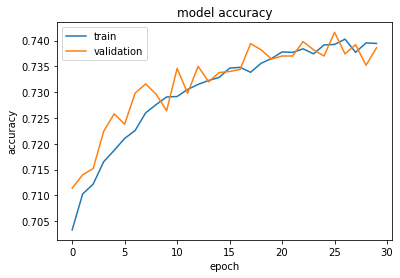

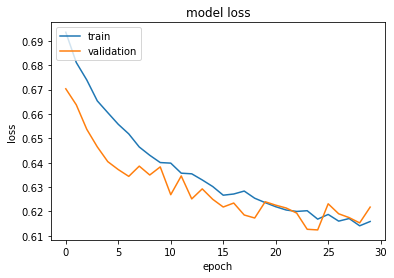

In [40]:
import matplotlib.pyplot as plt

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()